In [2]:
import patsy as pa
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import pandas as pd

tfd = tfp.distributions

from PriorLearning.elicitation_wrapper import expert_model
from PriorLearning.training import trainer
from PriorLearning.helper_functions import group_obs, Exponential_unconstrained, Normal_unconstrained
from PriorLearning.user_config import target_config, target_input
from PriorLearning.helper_functions import _print_restab, _plot_expert_preds, _group_stats, _plot_priors_flow
from PriorLearning._case_studies import truth_data_dmatrix, plot_expert_pred, tab_expert_pred, plot_priors_normal, expert_pred_elicits_normal, print_target_info, plot_learned_prior_linreg, plot_diagnostics_linreg
import PriorLearning.combine_losses 

from tabulate import tabulate
import pprint
pp = pprint.PrettyPrinter(depth=4)

tf.random.set_seed(2024)

# Normal regression model
## Background: Case Study
We focus on an experiment conducted by Unkelbach & Rom (2020), where participants are presented with general knowledge statements in two consecutive phases. During the second phase, they are required to indicate whether each statement is true or false. The response variable of interest is the proportion of true judgments (PTJs). The main objective of the study is to investigate the influence of two factors on PTJs: (1) repetition (ReP), which involves presenting some statements from the first phase again in the second phase, and (2) encoding depth (EnC), where participants are divided into groups varying in the level of elaboration required for initial sentence processing in the first phase. We consider a 2 (ReP: repeated, new) $\times$ 3 (EnC: shallow, standard, deep) between-subject factorial design with treatment contrasts used for both factors. The baseline levels are set as new for ReP and deep for EnC. 

**Reference:**

Unkelbach, C., & Rom, S. C. (2017). A referential theory of the repetition-induced truth effect. *Cognition*, 160, 110-126.

## Data generating model
\begin{align*}
    y_i &\sim \text{Normal}(\theta_i, s)\\
    \theta_i &= \beta_0 + \beta_1x_1 + \beta_2x_2 + \beta_3x_3 + \beta_4x_4 + \beta_5x_5\\
    \beta_k &\sim \text{Normal}(\mu_k, \sigma_k) \quad \text{for }k=0,\ldots, 5\\
    s &\sim \text{Exponential}(\nu)
\end{align*}
Here, $𝑦_𝑖$ represents the responses for each observation $𝑖 = 1, \ldots , 𝑁$, assumed to follow a normal distribution with mean $\theta_𝑖$ and standard deviation $𝑠$. The expected value $\theta_𝑖$ is modeled as a linear function of two categorical predictors, ReP and EnC. The regression coefficients $\beta_𝑘$ for $𝑘 = 0, \ldots , 5$ are assigned normal prior distributions. Specifically, $\beta_0$ represents the PTJs for condition new-deep, while $\beta_1$ represents the difference in PTJs ($\Delta$PTJ) between repeated and new statements. Additionally, $\beta_2$ captures the $\Delta$PTJ for new statements in the shallow- vs. standard-encoding condition, $\beta_3$ represents the $\Delta$PTJ for new statements in the shallow- vs. deep-encoding condition, and $\beta_4$ and $\beta_5$ account for the interaction effects between ReP and EnC. The standard deviation 𝑠 of the normal likelihood follows an Exponential prior distribution with rate parameter $\nu$.

## Methodology: Workflow

+ For each mini-batch:
    + $i$ observations with $i = 1, \ldots, N$, 
    + $k$ regression coefficients with $k = 0,\ldots,6$,
    + $s$ samples from each prior distribution with $s=1,\ldots, M$
    + $g$ group means with $g = 1,\ldots,6$ (corresponding to a $2 \times 3$ factorial design

+ PriorSamples($\lambda = (\mu_k, \sigma_k, \nu)$):
\begin{align*}
\{\beta_k\}_s &\sim \text{Normal}(\mu_k, \exp\{\sigma_k\})\\
\{s\}_s &\sim \text{Exponential}(\nu)
\end{align*}
+ Generator($\beta_k, s$):
\begin{align*}
\{\theta_i\}_s &= \{\beta_k\}_s \times X_i\\
\bar{s} &= \frac{1}{M} \sum_{i=1}^M \{s\}_s\\
\{y_i\}_s &\sim \text{Normal}(\{\theta_i\}_s, \bar{s})\\
\end{align*}
+ Targets($\{y_i\}_s$):
\begin{align*}
\{\bar{y}_{g}\}_s &= \frac{1}{N_{g}} \sum_{i=1}^{N_{g}} \{y_i\}_s \quad \text{ for } g = 1,\ldots,6\\
\{\Delta_{eff}\}_s &= \{\bar{y}_{g1}\}_s - \{\bar{y}_{g2}\}_s \quad \text{ for } g1 = 3,4,5 \text{ and } g2 = 0,1,2\\
\{R^2\}_s &= \frac{Var(\{\theta_i\}_s)}{Var(\{y_i\}_s)} 
\end{align*}
+ Elicits($\{\bar{y}_{g}\}_s, \{\Delta_{eff}\}_s, \{R^2\}_s$)
\begin{align*}
\text{Quantile-based:} \quad &Q_p^{g} = Q_{p}^{g} \{y_i\}_s \quad \text{ for } g = 1,\ldots, 6, p = 0.1, \ldots, 0.9\\
\text{Quantile-based:} \quad &Q_p^{eff} = Q_{p}^{eff} \{\Delta_{eff}\}_s \quad \text{ for } eff = 1,2,3; p = 0.1, \ldots, 0.9\\
\text{Histogram-based:} \quad &\{R^2\}_s =\{R^2\}_s 
\end{align*}

## User specification

### Setting hyperparameter for the learning algorithm

In [3]:
# setting of hyperparameter of learning algorithm
user_config = dict(                    
        B = 2**8,                          
        rep = 300,                         
        epochs = 400,                      
        view_ep = 40,
        lr_decay = True,
        lr0 = 0.01, 
        lr_min = 0.01, 
        loss_dimensions = "m,n:B",   
        loss_discrepancy = "energy", 
        loss_scaling = "unscaled",         
        method = "hyperparameter_learning"  
        )

#### Define the design matrix

$\beta_0$ represents the PTJs for the baseline condition (new-deep), while $\beta_1$ represents the difference in PTJs ($\Delta$PTJ) between repeated and new statements. Additionally, $\beta_2$ captures the $\Delta$PTJ for new statements in the shallow- vs. standard-encoding condition, $\beta_3$ represents the $\Delta$PTJ for new statements in the shallow- vs. deep-encoding condition, and $\beta_4$ and $\beta_5$ account for the interaction effects between ReP and EnC. 

In [4]:
dmatrix, cmatrix = truth_data_dmatrix(fct1 = 2, fct2 = 3, N_group = 60)

df = pd.DataFrame(dmatrix)
df.columns = [f"b{i}" for i in range(dmatrix.shape[1])]
print(df.head(6))

    b0   b1   b2   b3   b4   b5
0  1.0  0.0  0.0  0.0  0.0  0.0
1  1.0  0.0  1.0  0.0  0.0  0.0
2  1.0  0.0  0.0  1.0  0.0  0.0
3  1.0  1.0  0.0  0.0  0.0  0.0
4  1.0  1.0  1.0  0.0  1.0  0.0
5  1.0  1.0  0.0  1.0  0.0  1.0


#### Setup the 'ideal agent'
+ The regression coefficients $\beta_k$ for $k=0,\ldots,5$ are assigned normal prior distributions. 
+ The standard deviation $s$ of the normal likelihood follows an Exponential prior distribution with rate parameter $\nu$.
+ To model the ideal expert, we assume the following ``true'' hyperparameters
\begin{align*}
    \lambda^* = (&\mu_0=0.12, \sigma_0=0.02, \mu_1=0.15, \sigma_1=0.02, \mu_2=-0.02, \sigma_2=0.06, \\
                & \mu_3=-0.03, \sigma_3=0.06, \mu_4=-0.02, \sigma_4=0.03, \mu_5=-0.04, \sigma_5=0.03, \\
                & \nu=9.00)
\end{align*}

In [5]:
# true hyperparameter values for ideal_expert
true_values = dict({
    "mu": [0.12, 0.15, -0.02, -0.03, -0.02, -0.04],
    "sigma": [0.02, 0.02, 0.06, 0.06, 0.03, 0.03],
    "nu": 9.
})

# model parameters
parameters_dict = dict()
for i in range(6):
    parameters_dict[f"beta_{i}"] = {
            "family":  Normal_unconstrained(),
            "true": tfd.Normal(true_values["mu"][i], true_values["sigma"][i]),
            "initialization": [tfd.Normal(0.,0.1), tfd.Uniform(-2.,-4.)]
            }

exp_dist = Exponential_unconstrained(user_config["rep"])
parameters_dict["sigma"] = {
        "family": exp_dist,
        "true": exp_dist(tf.math.log(true_values["nu"])),
        "initialization": [tfd.Uniform(1.,2.)]
        }

print("True hyperparameter values:")
pd.DataFrame(true_values)

True hyperparameter values:


,mu,sigma,nu
0,0.12,0.02,9.0
1,0.15,0.02,9.0
2,-0.02,0.06,9.0
3,-0.03,0.06,9.0
4,-0.02,0.03,9.0
5,-0.04,0.03,9.0


#### Define the data generating model

In [6]:
# generative model
class GenerativeModel(tf.Module):
    def __call__(self, 
                 parameters, # obligatory: samples from prior distributions; tf.Tensor
                 dmatrix,    # optional: design matrix; tf.Tensor
                 cmatrix,    # optional: contrast matrix; tf.Tensor
                 **kwargs    # obligatory: possibility for further keyword arguments is needed 
                 ):  
        
        # compute linear predictor term
        epred = parameters[:,:,0:6] @ tf.transpose(dmatrix)
        
        # define likelihood
        likelihood = tfd.Normal(
            loc = epred, 
            scale = tf.expand_dims(parameters[:,:,-1], -1))
        
        # sample prior predictive data
        ypred = likelihood.sample()
        
        # compute custom target quantity (here: group-differences)
        samples_grouped = group_obs(ypred, dmatrix, cmatrix)

        # compute mean difference between groups
        effect_list = []
        diffs = [(0,3), (1,4), (2,5)]
        for i in range(len(diffs)):
            # compute group difference
            diff = tf.math.subtract(
                samples_grouped[:, :, :, diffs[i][0]],
                samples_grouped[:, :, :, diffs[i][1]]
            )
            # average over individual obs within each group
            diff_mean = tf.reduce_mean(diff, axis=2)
            # collect all mean group differences
            effect_list.append(diff_mean)

        mean_effects = tf.stack(effect_list, axis=-1)

        # compute marginals
        ## factor repetition: new, repeated
        marg_ReP = tf.reduce_mean(
            tf.stack([tf.math.add_n([samples_grouped[:, :, :, i] for i in j]) for j in [range(3),range(3,6)]], 
                     axis = -1), 
            axis = 2)
     
        ## factor Encoding depth: deep, standard, shallow
        marg_EnC = tf.reduce_mean(
            tf.stack([tf.math.add_n([samples_grouped[:, :, :, i] for i in j]) for j in [[0,3],[1,4],[2,5]]], 
                     axis = -1), 
            axis = 2)
        
        return dict(likelihood = likelihood,          # obligatory: likelihood; callable
                    ypred = ypred,                    # obligatory: prior predictive data
                    epred = epred,                    # obligatory: samples from linear predictor
                    mean_effects = mean_effects,      # optional: custom target quantity
                    marginal_ReP = marg_ReP,          # optional: custom target quantity
                    marginal_EnC = marg_EnC           # optional: custom target quantity
                    )

#### Specify the target quantities and the elicitation technique
We assume that the analyst elicits the following target quantities from the expert: the expected PTJ for the marginal distribution of factor EnC (1) and ReP (2), the expected $\Delta$PTJ between repeated and new statements for each EnC level (3), and the expected $R^2$ defined as $R^2= \textrm{var}(\theta_i) / \textrm{var}(y_i)$ (4). 
Here $\textrm{var}(\theta_i)$ is the variance of the modeled predictive means and $\textrm{var}(y_i)$ the variance of the predictive observations including the residual variance.
To elicit this information from the expert, the analyst uses quantile-based elicitation for (1-3) and histogram elicitation for (4). 

In [7]:
 # define a custom function using the output from the generative model   
def custom_r2(ypred, epred, **kwargs):
    return tf.math.divide(tf.math.reduce_variance(epred, axis = -1), 
                          tf.math.reduce_variance(ypred, axis = -1))

# specify target quantity, elicitation technique and loss combination
t1 = target_config(target = "marginal_ReP", 
                   elicitation = "quantiles", 
                   combine_loss = "by-group", 
                   quantiles_specs = (10, 20, 30, 40, 50, 60, 70, 80, 90))
t2 = target_config(target = "marginal_EnC", 
                    elicitation = "quantiles", 
                    combine_loss = "by-group", 
                    quantiles_specs = (10, 20, 30, 40, 50, 60, 70, 80, 90)) 
t3 = target_config(target = "mean_effects", 
                   elicitation = "quantiles",
                   combine_loss = "by-group",
                   quantiles_specs = (10, 20, 30, 40, 50, 60, 70, 80, 90))
t4 = target_config(target = "R2", 
                   elicitation = "histogram",
                   combine_loss = "all",
                   custom_target_function = custom_r2)

target_info = target_input(t1, t2, t3, t4)

print_target_info(target_info)

,target,elicitation,combine_loss,custom_target_function,quantiles_specs
0,marginal_ReP,quantiles,by-group,None,"(10, 20, 30, 40, 50, 60, 70, 80, 90)"
1,marginal_EnC,quantiles,by-group,None,"(10, 20, 30, 40, 50, 60, 70, 80, 90)"
2,mean_effects,quantiles,by-group,None,"(10, 20, 30, 40, 50, 60, 70, 80, 90)"
3,R2,histogram,all,<function custom_r2 at 0x000001F8CBE87880>,None


### Simulate from the "ideal" expert

In [8]:
expert_res_list, prior_pred_res = expert_model(1, user_config["rep"],
                                   parameters_dict, GenerativeModel, target_info,
                                   method = "ideal_expert",
                                   dmatrix = dmatrix,
                                   cmatrix = cmatrix,
                                   dmatrix_fct = dmatrix)

# elicited statistics from the (ideal) expert
expert_res_list.keys()

dict_keys(['marginal_ReP_quant_0', 'marginal_EnC_quant_1', 'mean_effects_quant_2', 'R2_hist_3'])

#### Expert predictions

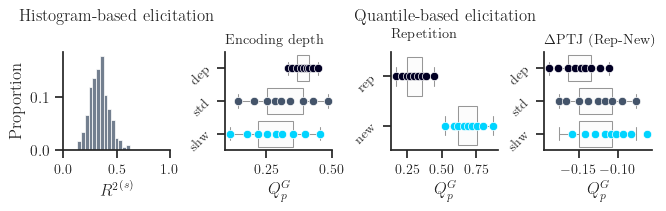

In [9]:
expert_pred_elicits_normal(expert_res_list, save_fig = False)

In [10]:
# group means
print(_group_stats(prior_pred_res["ypred"], num_groups = 6))
# mean effects
print("mean effects:")
print(np.round(tf.reduce_mean(prior_pred_res["mean_effects"],(0,1)),2))
# marginal distribution: Repetition
print("marginal ReP (new, repeated):")
print(np.round(tf.reduce_mean(prior_pred_res["marginal_ReP"],(0,1)),2))
# marginal distribution: Encoding depth
print("marginal EnC (deep, standard, shallow):")
print(np.round(tf.reduce_mean(prior_pred_res["marginal_EnC"],(0,1)),2))

+-------+------+------+
| group | mean | std  |
+-------+------+------+
|  gr_0 | 0.12 | 0.02 |
|  gr_1 | 0.09 | 0.06 |
|  gr_2 | 0.09 | 0.06 |
|  gr_3 | 0.27 | 0.03 |
|  gr_4 | 0.22 | 0.08 |
|  gr_5 | 0.2  | 0.07 |
+-------+------+------+
mean effects:
[-0.15 -0.13 -0.11]
marginal ReP (new, repeated):
[0.3  0.69]
marginal EnC (deep, standard, shallow):
[0.39 0.32 0.29]


### Learn the prior distributions
The learning process is considered completed once the maximum number of epochs has been reached. 

In [11]:
res_dict = trainer(expert_res_list, user_config["B"], user_config["rep"],
                   parameters_dict, user_config["method"], GenerativeModel,
                   target_info, user_config, loss_balancing = True, save_vals = ["prior_preds"],
                   dmatrix = dmatrix, cmatrix = cmatrix, dmatrix_fct = dmatrix)

epoch_time: 14.143 sec
Epoch: 0, loss: 0.39360, lr: 0.010000
epoch_time: 3.399 sec
Epoch: 40, loss: 0.05567, lr: 0.010000
epoch_time: 3.405 sec
Epoch: 80, loss: 0.02269, lr: 0.010000
epoch_time: 2.930 sec
Epoch: 120, loss: 0.01679, lr: 0.010000
epoch_time: 2.957 sec
Epoch: 160, loss: 0.01423, lr: 0.010000
epoch_time: 2.938 sec
Epoch: 200, loss: 0.01236, lr: 0.010000
epoch_time: 3.478 sec
Epoch: 240, loss: 0.01173, lr: 0.010000
epoch_time: 2.993 sec
Epoch: 280, loss: 0.01118, lr: 0.010000
epoch_time: 3.443 sec
Epoch: 320, loss: 0.01094, lr: 0.010000
epoch_time: 2.930 sec
Epoch: 360, loss: 0.01069, lr: 0.010000
 
Total time needed: 21.75 min


## Results

### Diagnostics and Convergence plots


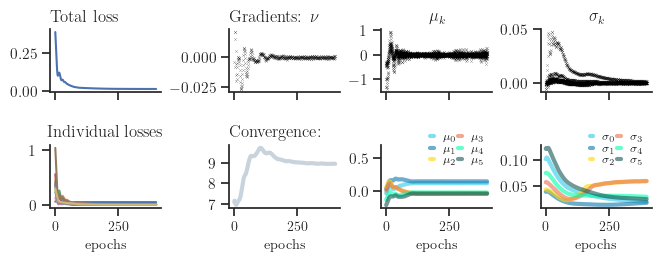

In [12]:
plot_diagnostics_linreg(res_dict, user_config, save_fig = True)

### Final learned hyperparameter values
Simulation results indicate a close match between the prior predictions obtained from our final learned model and the expert's elicited statistics.

In [13]:
true_vals = [j for i in zip(true_values["mu"],true_values["sigma"]) for j in i]
true_vals += [true_values["nu"]]

tab, avg_res = _print_restab(method = "hyperparameter_learning", 
                             num_vars = 13, 
                             res = res_dict["hyperparam_info"], 
                             start = 30, 
                             precision = 3, 
                             true_values = true_vals)

### Learned prior distributions
The learned prior distributions are depicted with solid lines, while the true priors (according to the ideal expert) are represented by dotted lines. Note, the final learned hyperparameter $\lambda$ is computed as the average over the last 30 epochs.
The substantial overlap between these distributions indicates a successful learning process. 

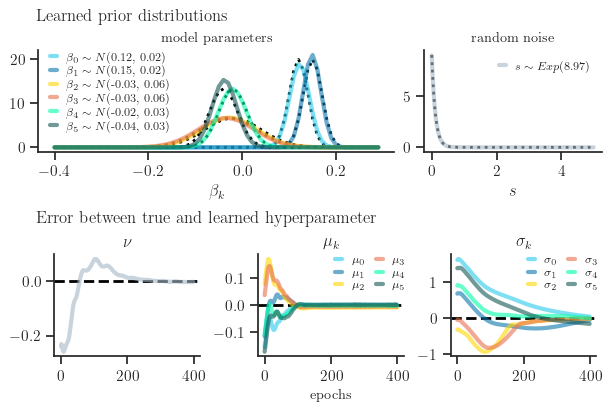

In [14]:
plot_learned_prior_linreg(res_dict, true_vals, avg_res, user_config["epochs"], save_fig = True)